In [1]:
import os
import pickle
import numpy as np
from tqdm.notebook import tqdm

from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add

In [2]:

model = VGG16()

model = Model(inputs=model.inputs, outputs=model.layers[-2].output)

2022-11-08 06:31:14.930621: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


553476096/553467096 [==============================] - 19s 0us/step


In [4]:
BASE_DIR = '../input/flickr8k'
features = {}
directory = os.path.join(BASE_DIR, 'Images')

for i in tqdm(os.listdir(directory)):
    img_path = directory + '/' + i
    image = load_img(img_path, target_size=(224, 224))
    image = img_to_array(image)
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    image = preprocess_input(image)
    feature = model.predict(image, verbose=0)
    image_id = i.split('.')[0]
    features[image_id] = feature

pickle.dump(features, open(os.path.join(BASE_DIR, 'features.pkl'), 'wb'))

  0%|          | 0/8091 [00:00<?, ?it/s]

OSError: [Errno 30] Read-only file system: '../input/flickr8k/features.pkl'

In [5]:
'features.pkl'), 'rb') as f:
    features = pickle.load(f)

In [6]:

with open(os.path.join(BASE_DIR, 'captions.txt'), 'r') as f:
    next(f)
    desc_doc = f.read()

In [7]:

mapping = {}
for each_desc in tqdm(desc_doc.split('\n')):
    tokens = each_desc.split(',')
    if len(each_desc) < 2:
        continue
    image_id, desc_of = tokens[0], tokens[1:]
    image_id = image_id.split('.')[0]
    desc_of = " ".join(desc_of)
    if image_id not in mapping:
        mapping[image_id] = []
    mapping[image_id].append(desc_of)

  0%|          | 0/40456 [00:00<?, ?it/s]

In [8]:

def edit_description(mapping):
    for key, desc in mapping.items():
        for i in range(len(desc)):
            x = desc[i]
            x = x.lower()
            x = x.replace('[^A-Za-z]', '')
            x = x.replace('\s+', ' ')
            x = 'beginning ' + " ".join([word for word in x.split() if len(word)>1]) + ' ending'
            desc[i] = x

In [9]:

edit_description(mapping)

In [10]:

img_desc = []
for key in mapping:
    for caption in mapping[key]:
        img_desc.append(caption)

In [11]:

tokenizer = Tokenizer()
tokenizer.fit_on_texts(img_desc)
vocab_size = len(tokenizer.word_index) + 1

In [12]:
print("Unique words in the captions are: " + str(vocab_size))

Unique words in the captions are: 8484


In [13]:

max_length = max(len(text.split()) for text in img_desc)
max_length

35

In [14]:

image_ids = list(mapping.keys())
split = int(len(image_ids) * 0.90)
train = image_ids[:split]
test = image_ids[split:]

In [15]:

def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    X1, X2, y = list(), list(), list()
    n = 0
    while 1:
        for key in data_keys:
            n += 1
            text = mapping[key]
            for t in text:
                seq = tokenizer.texts_to_sequences([t])[0]
                for i in range(1, len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)
            if n == batch_size:
                X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                yield [X1, X2], y
                X1, X2, y = list(), list(), list()
                n = 0

In [16]:


inputs1 = Input(shape=(4096,))
fe1 = Dropout(0.4)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)

inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.4)(se1)
se3 = LSTM(256)(se2)

decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')

In [18]:

epochs = 20
batch_size = 32
steps = len(train) // batch_size

for i in range(epochs):
    generator = data_generator(train, mapping, features, tokenizer, max_length, vocab_size, batch_size)
    model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)

model.save('best_model.h5')

227/227 [==============================] - 610s 3s/step - loss: 2.1849


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [49]:
def mapping_toword(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

In [50]:
def predict_description(model, image, tokenizer, max_length):
    in_text = 'beginning'
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], max_length)
        desc_predict = model.predict([image, sequence], verbose=0)

        desc_predict = np.argmax(desc_predict)
        word = mapping_toword(desc_predict, tokenizer)
        if word is None:
            break
        in_text += " " + word
        if word == 'ending':
            break
      
    return in_text

In [51]:
actual, predicted = list(), list()

for key in tqdm(test):
    desc = mapping[key]
    y_pred = predict_description(model, features[key], tokenizer, max_length) 
    actual_desc = [caption.split() for text in desc]
    y_pred = y_pred.split()
    actual.append(actual_desc)
    predicted.append(y_pred)

  0%|          | 0/810 [00:00<?, ?it/s]

In [52]:
!pip install pyttsx3

  Using cached pyttsx3-2.90-py3-none-any.whl (39 kB)


In [53]:
from PIL import Image
import matplotlib.pyplot as plt
def generate_text(image_name):
    image_id = image_name.split('.')[0]
    img_path = os.path.join(BASE_DIR, "Images", image_name)
    image = Image.open(img_path)
    desc = mapping[image_id]
    y_pred = predict_description(model, features[image_id], tokenizer, max_length)
    plt.imshow(image)

    return str(y_pred)

In [54]:


!pip3 install gTTS pyttsx3 playsound pygobject

  Using cached gTTS-2.2.4-py3-none-any.whl (26 kB)
  Using cached playsound-1.3.0-py3-none-any.whl
  Using cached PyGObject-3.42.2.tar.gz (719 kB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached pycairo-1.21.0-cp37-cp37m-linux_x86_64.whl
  error: subprocess-exited-with-error
  
  × Building wheel for pygobject (pyproject.toml) did not run successfully.
  │ exit code: 1
  ╰─> [44 lines of output]
      running bdist_wheel
      running build
      running build_py
      creating build
      creating build/lib.linux-x86_64-cpython-37
      creating build/lib.linux-x86_64-cpython-37/pygtkcompat
      copying pygtkcompat/__init__.py -> build/lib.linux-x86_64-cpython-37/pygtkcompat
      copying pygtkcompat/generictreemodel.py -> build/lib.linux-x86_64-cpython-37/pygtkcompat
      copying pygtkcompat/pygtkcompat.py -> build/lib.linux-x86_64-cpython-37/pygtkcompat
      creating build/lib.li

In [27]:
pip install SpeechRecognition

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 32.8/32.8 MB 20.8 MB/s eta 0:00:0000:0100:01
Note: you may need to restart the kernel to use updated packages.


In [68]:

import os
import speech_recognition as sr
import pyttsx3


def voice_output(command):
    engine = pyttsx3.init()
    engine.say(command)
    engine.runAndWait()
r = sr.Recognizer()
x = 0



In [70]:
!pip install gTTs

  Using cached gTTS-2.2.4-py3-none-any.whl (26 kB)


beginning dog with brown eyes is playing with ball in the grass ending


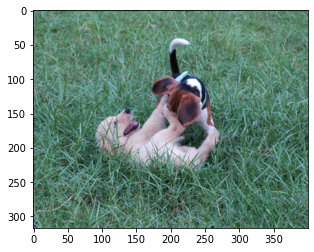

In [75]:
from gtts import gTTS
from IPython.display import Audio

text = str(generate_text("23445819_3a458716c1.jpg"))
print(text)

res = text.split(' ', 1)[1]
text = res.rsplit(' ', 1)[0]

tts = gTTS(text) 

tts.save('info.wav')
sound_file = 'info.wav'
Audio(sound_file, autoplay=True) 

In [ ]:
text = str(generate_text("1001773457_577c3a7d70.jpg"))
print(text)

res = text.split(' ', 1)[1]
text = res.rsplit(' ', 1)[0]

tts = gTTS(text) 

tts.save('info.wav')
sound_file = 'info.wav'
Audio(sound_file, autoplay=True)

: 

beginning little girl in green dress is sitting in front of rainbow rainbow in green rainbow ending


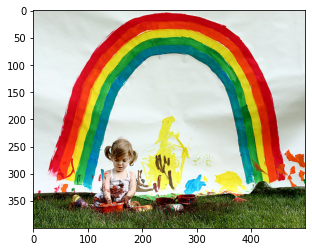

In [76]:
text = str(generate_text("1002674143_1b742ab4b8.jpg"))
print(text)

res = text.split(' ', 1)[1]
text = res.rsplit(' ', 1)[0]

tts = gTTS(text) 

tts.save('info.wav')
sound_file = 'info.wav'
Audio(sound_file, autoplay=True)